In [186]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,plot_confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score

## Define the data path - Customize for your own data

In [42]:
PATH = "/Users/iremn/PythonClass/Spiced/gradient_garlic-code_Work/Week_02/Day_5"
FEATURES = "pumps.csv"
TARGET = "pumps_y.csv"

In [43]:
#Join
FEATURES = os.path.join(PATH, FEATURES)
TARGET = os.path.join(PATH, TARGET)

## Read the Pumps Data

In [44]:
pumps_f = pd.read_csv(FEATURES, index_col = 0)
pumps_y = pd.read_csv(TARGET, index_col = 0)


## Train_Test Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(pumps_f, pumps_y, test_size = 0.2, random_state=42)

## Data Peek

In [46]:
X_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
454,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,Internal,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
510,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,Internal,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14146,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,Lake Rukwa,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
47410,0.0,2011-04-12,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,Rufiji,...,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
1288,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,Wami / Ruvu,...,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [47]:
X_train.shape

(47520, 39)

In [48]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 39 columns):
amount_tsh               47520 non-null float64
date_recorded            47520 non-null object
funder                   44644 non-null object
gps_height               47520 non-null int64
installer                44631 non-null object
longitude                47520 non-null float64
latitude                 47520 non-null float64
wpt_name                 47520 non-null object
num_private              47520 non-null int64
basin                    47520 non-null object
subvillage               47224 non-null object
region                   47520 non-null object
region_code              47520 non-null int64
district_code            47520 non-null int64
lga                      47520 non-null object
ward                     47520 non-null object
population               47520 non-null int64
public_meeting           44831 non-null object
recorded_by              47520 non-null objec

In [49]:
#Check the unique vals within those columns
X_train.nunique()

amount_tsh                  96
date_recorded              351
funder                    1698
gps_height                2401
installer                 1923
longitude                46043
latitude                 46044
wpt_name                 30742
num_private                 59
basin                        9
subvillage               17232
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2076
population                 971
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2541
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity

* Seems like there are some redundant columns such as "quantity" and "quantity_group" and so on. One can drop those columns
* Split the categorical and numerical features
* Do EDA, wrangle data but don't forget to do all with test data too

In [50]:
pumps_num = X_train.select_dtypes(exclude ='object') 
pumps_cat = X_train.select_dtypes(include = 'object')

In [51]:
pumps_num.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
id,,,,,,,,,
454,50.0,2092,35.426020,-4.227446,0,21,1,160,1998
510,0.0,0,35.510074,-5.724555,0,1,6,0,0
14146,0.0,0,32.499866,-9.081222,0,12,6,0,0
47410,0.0,0,34.060484,-8.830208,0,12,7,0,0
1288,300.0,1023,37.032690,-6.040787,0,5,1,120,1997


In [52]:
pumps_cat.head()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
454,2013-02-27,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
510,2011-03-17,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14146,2011-07-10,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
47410,2011-04-12,NaN,NaN,Shule Ya Msingi Chosi A,Rufiji,Shuleni,Mbeya,Mbarali,Chimala,True,...,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
1288,2011-04-05,Ki,Ki,Kwa Mjowe,Wami / Ruvu,Ngholong,Morogoro,Kilosa,Chakwale,True,...,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [53]:
pumps_num['date_recorded'] = pumps_cat['date_recorded']
pumps_cat = pumps_cat.drop('date_recorded', axis = 1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Work on the categorical columns

In [54]:
pumps_cat.head()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
454,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,GeoData Consultants Ltd,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
510,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,GeoData Consultants Ltd,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14146,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,GeoData Consultants Ltd,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
47410,NaN,NaN,Shule Ya Msingi Chosi A,Rufiji,Shuleni,Mbeya,Mbarali,Chimala,True,GeoData Consultants Ltd,...,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
1288,Ki,Ki,Kwa Mjowe,Wami / Ruvu,Ngholong,Morogoro,Kilosa,Chakwale,True,GeoData Consultants Ltd,...,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [55]:
pumps_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 29 columns):
funder                   44644 non-null object
installer                44631 non-null object
wpt_name                 47520 non-null object
basin                    47520 non-null object
subvillage               47224 non-null object
region                   47520 non-null object
lga                      47520 non-null object
ward                     47520 non-null object
public_meeting           44831 non-null object
recorded_by              47520 non-null object
scheme_management        44418 non-null object
scheme_name              24997 non-null object
permit                   45081 non-null object
extraction_type          47520 non-null object
extraction_type_group    47520 non-null object
extraction_type_class    47520 non-null object
management               47520 non-null object
management_group         47520 non-null object
payment                  47520 non-null obj

In [56]:
pumps_cat.nunique()

funder                    1698
installer                 1923
wpt_name                 30742
basin                        9
subvillage               17232
region                      21
lga                        125
ward                      2076
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2541
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

Looks like "recorded by" has a single value - drop it

In [57]:
pumps_cat = pumps_cat.drop('recorded_by', axis=1)

### Fill cat NaNs with "not available"

In [69]:
pumps_cat = pumps_cat.fillna('not available')

In [74]:
pumps_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 28 columns):
funder                   47520 non-null object
installer                47520 non-null object
wpt_name                 47520 non-null object
basin                    47520 non-null object
subvillage               47520 non-null object
region                   47520 non-null object
lga                      47520 non-null object
ward                     47520 non-null object
public_meeting           47520 non-null object
scheme_management        47520 non-null object
scheme_name              47520 non-null object
permit                   47520 non-null object
extraction_type          47520 non-null object
extraction_type_group    47520 non-null object
extraction_type_class    47520 non-null object
management               47520 non-null object
management_group         47520 non-null object
payment                  47520 non-null object
payment_type             47520 non-null obj

In [75]:
pumps_cat.nunique()

funder                    1699
installer                 1924
wpt_name                 30742
basin                        9
subvillage               17233
region                      21
lga                        125
ward                      2076
public_meeting               3
scheme_management           13
scheme_name               2542
permit                       3
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

### Remove Unnecessary Redundant Cols

In [76]:
#Remove some categorical vars
garbage_cat = ['extraction_type_group','extraction_type_class',
               'waterpoint_type_group','source_type',
              'payment_type','quality_group','quantity_group']

In [77]:
pumps_cat = pumps_cat.drop(columns=garbage_cat)

In [78]:
pumps_cat.columns

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'scheme_management', 'scheme_name',
       'permit', 'extraction_type', 'management', 'management_group',
       'payment', 'water_quality', 'quantity', 'source', 'source_class',
       'waterpoint_type'],
      dtype='object')

## Handle Numerical data

In [80]:
pumps_num.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,date_recorded
id,,,,,,,,,,
454,50.0,2092,35.426020,-4.227446,0,21,1,160,1998,2013-02-27
510,0.0,0,35.510074,-5.724555,0,1,6,0,0,2011-03-17
14146,0.0,0,32.499866,-9.081222,0,12,6,0,0,2011-07-10
47410,0.0,0,34.060484,-8.830208,0,12,7,0,0,2011-04-12
1288,300.0,1023,37.032690,-6.040787,0,5,1,120,1997,2011-04-05


In [81]:
pumps_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 10 columns):
amount_tsh           47520 non-null float64
gps_height           47520 non-null int64
longitude            47520 non-null float64
latitude             47520 non-null float64
num_private          47520 non-null int64
region_code          47520 non-null int64
district_code        47520 non-null int64
population           47520 non-null int64
construction_year    47520 non-null int64
date_recorded        47520 non-null object
dtypes: float64(3), int64(6), object(1)
memory usage: 4.0+ MB


In [83]:
#Convert date recorded to datetime
pumps_num['recorded'] = pd.to_datetime(pumps_num['date_recorded'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [85]:
pumps_num['recorded_year'] = pumps_num['recorded'].dt.year

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [86]:
pumps_num.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,date_recorded,recorded,recorded_year
id,,,,,,,,,,,,
454,50.0,2092,35.426020,-4.227446,0,21,1,160,1998,2013-02-27,2013-02-27,2013
510,0.0,0,35.510074,-5.724555,0,1,6,0,0,2011-03-17,2011-03-17,2011
14146,0.0,0,32.499866,-9.081222,0,12,6,0,0,2011-07-10,2011-07-10,2011
47410,0.0,0,34.060484,-8.830208,0,12,7,0,0,2011-04-12,2011-04-12,2011
1288,300.0,1023,37.032690,-6.040787,0,5,1,120,1997,2011-04-05,2011-04-05,2011


In [99]:
#Impute mean construction_year
mean_imputer = SimpleImputer(missing_values=0, strategy='mean')
pumps_num['construction_year_imp'] = mean_imputer.fit_transform(pumps_num['construction_year'].values.reshape(-1,1))
pumps_num['construction_year_imp'] = pumps_num['construction_year_imp'].astype('int')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [101]:
pumps_num['age'] = pumps_num['recorded_year'] - pumps_num['construction_year_imp']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [102]:
pumps_num.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,date_recorded,recorded,recorded_year,construction_year_imp,age
id,,,,,,,,,,,,,,
454,50.0,2092,35.426020,-4.227446,0,21,1,160,1998,2013-02-27,2013-02-27,2013,1998,15
510,0.0,0,35.510074,-5.724555,0,1,6,0,0,2011-03-17,2011-03-17,2011,1996,15
14146,0.0,0,32.499866,-9.081222,0,12,6,0,0,2011-07-10,2011-07-10,2011,1996,15
47410,0.0,0,34.060484,-8.830208,0,12,7,0,0,2011-04-12,2011-04-12,2011,1996,15
1288,300.0,1023,37.032690,-6.040787,0,5,1,120,1997,2011-04-05,2011-04-05,2011,1997,14


There are some categorical variables leaked in here:
- region_code
- district_code

In [103]:
pumps_cat[['region_code', 'district_code']] = pumps_num[['region_code', 'district_code']]

In [106]:
pumps_num = pumps_num.drop(['region_code', 'district_code'], axis = 1)

In [107]:
pumps_num.head()

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,date_recorded,recorded,recorded_year,construction_year_imp,age
id,,,,,,,,,,,,
454,50.0,2092,35.426020,-4.227446,0,160,1998,2013-02-27,2013-02-27,2013,1998,15
510,0.0,0,35.510074,-5.724555,0,0,0,2011-03-17,2011-03-17,2011,1996,15
14146,0.0,0,32.499866,-9.081222,0,0,0,2011-07-10,2011-07-10,2011,1996,15
47410,0.0,0,34.060484,-8.830208,0,0,0,2011-04-12,2011-04-12,2011,1996,15
1288,300.0,1023,37.032690,-6.040787,0,120,1997,2011-04-05,2011-04-05,2011,1997,14


In [109]:
pumps_num_copy = pumps_num[['amount_tsh', 'age', 'construction_year_imp', 'population', 'gps_height']]

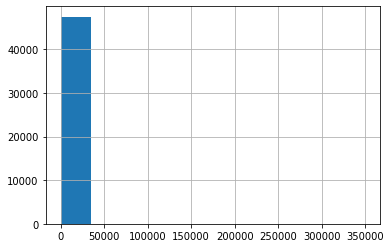

In [110]:
pumps_num_copy['amount_tsh'].hist()

In [114]:
pumps_num_copy['amount_tsh'].unique()

array([5.00e+01, 0.00e+00, 3.00e+02, 1.00e+01, 8.00e+03, 2.50e+02,
       5.00e+02, 3.00e+01, 1.00e+03, 6.00e+03, 1.00e+02, 4.70e+03,
       4.00e+01, 1.50e+03, 2.40e+03, 2.00e+03, 1.50e+01, 1.00e+04,
       5.00e+00, 2.00e+01, 3.00e+03, 2.00e+02, 6.00e+02, 2.50e+03,
       5.00e+03, 2.50e+01, 4.00e+02, 8.50e+03, 4.50e+02, 6.00e+00,
       1.20e+03, 4.00e+03, 7.50e+02, 7.00e+02, 7.00e+00, 1.63e+04,
       3.60e+03, 1.20e+04, 2.50e+04, 1.50e+04, 1.50e+02, 2.20e+03,
       7.20e+03, 2.00e+00, 2.00e+04, 2.80e+03, 7.00e+01, 1.20e+01,
       3.50e+03, 4.00e+04, 3.30e+01, 3.50e+01, 7.00e+03, 1.17e+05,
       7.50e+03, 6.00e+01, 1.30e+03, 7.00e+04, 5.00e+04, 6.50e+03,
       2.00e+05, 1.10e+04, 3.00e+04, 4.50e+03, 6.30e+03, 1.40e+04,
       3.50e+05, 3.50e+02, 9.00e+00, 4.50e+04, 2.60e+04, 1.60e+04,
       2.00e-01, 5.20e+02, 8.00e+02, 6.00e+04, 9.00e+03, 5.50e+02,
       5.50e+03, 2.20e+02, 3.06e+02, 2.60e+01, 1.70e+05, 1.30e+04,
       5.90e+02, 1.00e+00, 1.20e+05, 5.30e+01, 1.80e+04, 5.40e

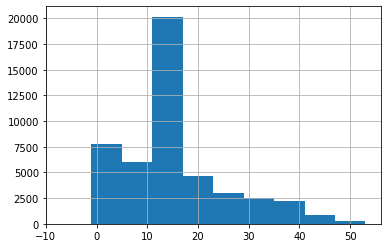

In [115]:
pumps_num_copy['age'].hist()

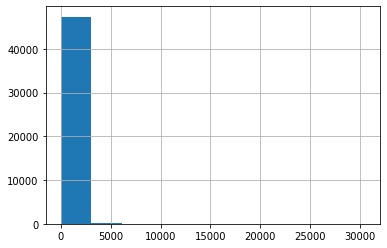

In [116]:
pumps_num_copy['population'].hist()

In [118]:
scaler = RobustScaler()
nums_scaled = scaler.fit_transform(pumps_num_copy)

In [120]:
nums_scaled = pd.DataFrame(nums_scaled, columns=pumps_num_copy.columns)

### Back to categoricals

In [122]:
pumps_cat.head()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,scheme_management,...,management,management_group,payment,water_quality,quantity,source,source_class,waterpoint_type,region_code,district_code
id,,,,,,,,,,,,,,,,,,,,,
454,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,Water Board,...,water board,user-group,pay per bucket,soft,insufficient,spring,groundwater,communal standpipe,21,1
510,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,VWC,...,vwc,user-group,never pay,soft,enough,shallow well,groundwater,hand pump,1,6
14146,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,VWC,...,vwc,user-group,never pay,soft,enough,shallow well,groundwater,other,12,6
47410,not available,not available,Shule Ya Msingi Chosi A,Rufiji,Shuleni,Mbeya,Mbarali,Chimala,True,VWC,...,vwc,user-group,pay monthly,soft,insufficient,river,surface,communal standpipe,12,7
1288,Ki,Ki,Kwa Mjowe,Wami / Ruvu,Ngholong,Morogoro,Kilosa,Chakwale,True,VWC,...,vwc,user-group,pay when scheme fails,salty,enough,shallow well,groundwater,other,5,1


In [125]:
pumps_cat[['region_code', 'district_code']] = pumps_cat[['region_code', 'district_code']].astype('str')

In [128]:
pumps_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 23 columns):
funder               47520 non-null object
installer            47520 non-null object
wpt_name             47520 non-null object
basin                47520 non-null object
subvillage           47520 non-null object
region               47520 non-null object
lga                  47520 non-null object
ward                 47520 non-null object
public_meeting       47520 non-null object
scheme_management    47520 non-null object
scheme_name          47520 non-null object
permit               47520 non-null object
extraction_type      47520 non-null object
management           47520 non-null object
management_group     47520 non-null object
payment              47520 non-null object
water_quality        47520 non-null object
quantity             47520 non-null object
source               47520 non-null object
source_class         47520 non-null object
waterpoint_type      47520 no

In [133]:
pumps_cat.nunique()

funder                1699
installer             1924
wpt_name             30742
basin                    9
subvillage           17233
region                  21
lga                    125
ward                  2076
public_meeting           3
scheme_management       13
scheme_name           2542
permit                   3
extraction_type         18
management              12
management_group         5
payment                  7
water_quality            8
quantity                 5
source                  10
source_class             3
waterpoint_type          7
region_code             27
district_code           20
dtype: int64

In [134]:
cat_copy = pumps_cat[['extraction_type', 'payment', 'quantity', 'waterpoint_type', 'source_class']]

In [139]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
cats_ohe = ohe.fit_transform(cat_copy)

In [154]:
cats_ohe.shape

(47520, 40)

In [151]:
#Get column names
column_names_cat = []
for col in ohe.categories_:
    for sub_cat in col:
        column_names_cat.append(sub_cat)
    

In [158]:
len(column_names_cat)

40

In [159]:
cats_ohe_df = pd.DataFrame(cats_ohe, columns = column_names_cat)

In [161]:
cats_ohe_df.head()

,afridev,cemo,climax,gravity,india mark ii,india mark iii,ksb,mono,nira/tanira,other,...,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other,groundwater,surface,unknown
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


### Final DF

In [163]:
pumps_final = pd.concat([cats_ohe_df, nums_scaled], axis = 1)

In [164]:
pumps_final.head()

,afridev,cemo,climax,gravity,india mark ii,india mark iii,ksb,mono,nira/tanira,other,...,improved spring,other,groundwater,surface,unknown,amount_tsh,age,construction_year_imp,population,gps_height
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.5,0.000000,0.250,0.633803,1.304545
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000,-0.117371,-0.280303
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.000,-0.117371,-0.280303
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000,-0.117371,-0.280303
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,15.0,-0.111111,0.125,0.446009,0.494697


In [68]:
#Check if the target variables are balanced - ADDRESS this in the end but DO NOT Apply to TEST
y_train['status_group'].value_counts()

functional                 25802
non functional             18252
functional needs repair     3466
Name: status_group, dtype: int64

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


## LogReg

In [204]:
logreg = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced', solver = 'liblinear', multi_class='ovr')

In [205]:
logreg.fit(pumps_final, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [206]:
y_pred = logreg.predict(pumps_final)

In [207]:
y_proba_pred = logreg.predict_proba(pumps_final)

In [208]:
accuracy_score(y_train, y_pred)

0.7028409090909091

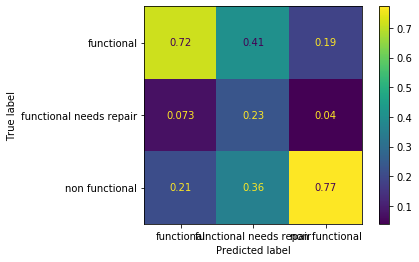

In [209]:
plot_confusion_matrix(logreg,pumps_final, y_train, normalize='pred')

In [210]:
precision_score(y_train, y_pred, average='weighted')

0.7023872453491035

In [211]:
recall_score(y_train, y_pred, average='weighted')

0.7028409090909091

In [212]:
f1_score(y_train, y_pred, average='weighted')

0.6943763181410805

### Random Forest

In [218]:
rf = RandomForestClassifier(class_weight='balanced')

# Parameter Grid 

param_grid = {
    'max_depth': [1, 5, 8, 32],#, 8, 32, 128, None],
    'n_estimators': [10, 100, 1000]#, 100, 1000, 1000]
}

In [219]:
cv = GridSearchCV(rf, param_grid, 
                  cv=5, n_jobs=4)

cv.fit(pumps_final, y_train)
print('Performing Random Forest...')

res = pd.DataFrame(cv.cv_results_)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Performing Random Forest...


In [225]:
params = res.sort_values(by='rank_test_score').iloc[0]['params']

In [245]:
rf_cv = RandomForestClassifier(max_depth = params['max_depth'], n_estimators=params['n_estimators'], class_weight='balanced')

In [246]:
rf_cv.fit(pumps_final, y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [247]:
y_pred_rf = rf_cv.predict(pumps_final)

In [248]:
y_pred_rf_proba = rf_cv.predict_proba(pumps_final)

In [249]:
accuracy_score(y_train, y_pred_rf)

0.876746632996633

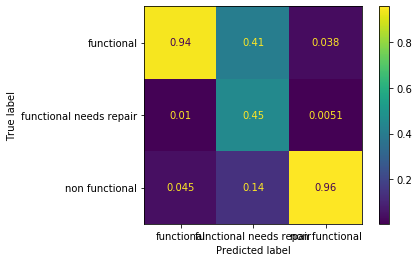

In [250]:
plot_confusion_matrix(rf_cv,pumps_final, y_train, normalize='pred')

In [251]:
precision_score(y_train, y_pred_rf, average='weighted')

0.9130733702513104

In [252]:
recall_score(y_train, y_pred_rf, average='weighted')

0.876746632996633

In [268]:
feature_label = pumps_final.columns
feature_importance_idx =np.argsort(rf_cv.feature_importances_)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [265]:
feature_importance_idx

array([10, 33, 11,  1,  2,  5, 16, 30, 17, 13, 39, 12, 29,  4, 19, 35,  0,
       15,  6,  7, 20, 14, 23,  8, 34, 28, 37, 21, 32, 22, 24, 38, 31, 18,
       27,  3, 26, 36,  9, 40, 25, 42, 41, 43, 44])

In [269]:
feature_importance_sorted = []
for idx in feature_importance_idx:
    feature_importance_sorted.append(rf_cv.feature_importances_[idx])

In [271]:
feature_label_sorted = []
for idx in feature_importance_idx:
    feature_label_sorted.append(pumps_final.columns[idx])

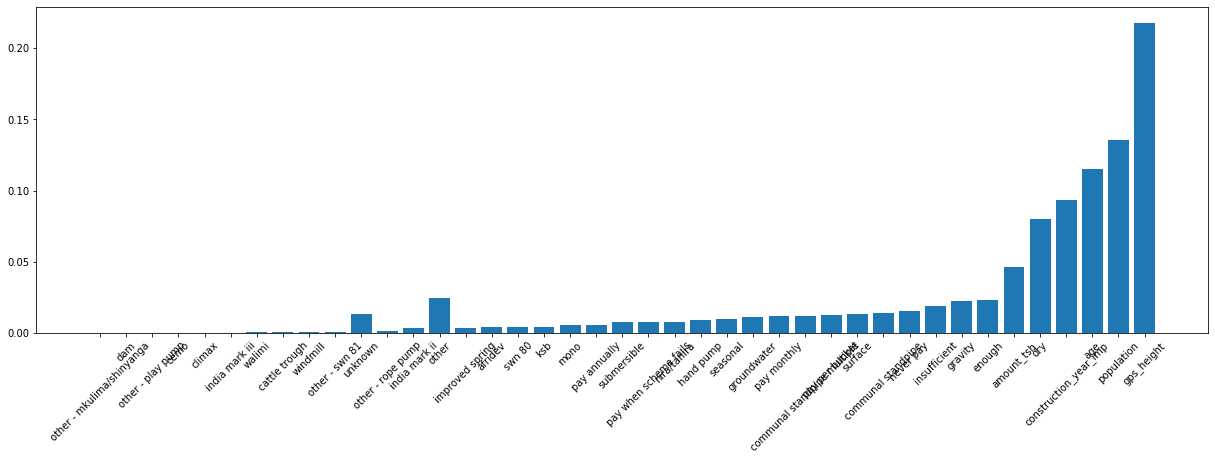

In [274]:
fig= plt.figure(figsize=(21,6))
plt.bar(feature_label_sorted, feature_importance_sorted)
plt.xticks(rotation=45)
plt.show()

In [285]:
## Refine take the first six features
subset = feature_label_sorted[-5:]

In [286]:
subset

['dry', 'construction_year_imp', 'age', 'population', 'gps_height']

In [287]:
pumps_subset = pumps_final[subset]

In [301]:
pumps_subset

,dry,construction_year_imp,age,population,gps_height
0,0.0,0.250,0.000000,0.633803,1.304545
1,0.0,0.000,0.000000,-0.117371,-0.280303
2,0.0,0.000,0.000000,-0.117371,-0.280303
3,0.0,0.000,0.000000,-0.117371,-0.280303
4,0.0,0.125,-0.111111,0.446009,0.494697
5,0.0,0.000,0.000000,-0.117371,-0.280303
6,0.0,0.000,0.222222,-0.117371,-0.280303
7,0.0,1.625,-1.444444,1.056338,-0.054545
8,0.0,0.000,0.000000,-0.117371,-0.280303
9,0.0,1.625,-1.222222,7.018779,0.584091


In [288]:
rf = RandomForestClassifier(class_weight='balanced')

# Parameter Grid 

param_grid = {
    'max_depth': [1, 5, 8, 32],#, 8, 32, 128, None],
    'n_estimators': [10, 100, 1000]#, 100, 1000, 1000]
}

In [289]:
cv = GridSearchCV(rf, param_grid, 
                  cv=5, n_jobs=4)

cv.fit(pumps_subset, y_train)
print('Performing Random Forest...')

res = pd.DataFrame(cv.cv_results_)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Performing Random Forest...


In [290]:
params = res.sort_values(by='rank_test_score').iloc[0]['params']

In [291]:
rf_cv = RandomForestClassifier(max_depth = params['max_depth'], n_estimators=params['n_estimators'], class_weight='balanced')

In [292]:
rf_cv.fit(pumps_subset, y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [293]:
y_pred_rf_sub = rf_cv.predict(pumps_subset)

In [294]:
y_pred_rf_proba_sub = rf_cv.predict_proba(pumps_subset)

In [295]:
accuracy_score(y_train, y_pred_rf_sub)

0.7736531986531987

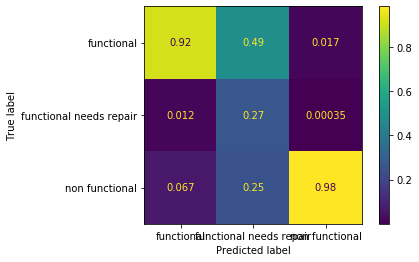

In [296]:
plot_confusion_matrix(rf_cv,pumps_subset, y_train, normalize='pred')

In [299]:
print('Precision is: ', precision_score(y_train, y_pred_rf_sub, average='weighted'))
print('Recall is: ', recall_score(y_train, y_pred_rf_sub, average='weighted'))
print('f1 score is: ', f1_score(y_train, y_pred_rf_sub, average='weighted'))


Precision is:  0.8971888146754685
Recall is:  0.7736531986531987
f1 score is:  0.8126206278532062


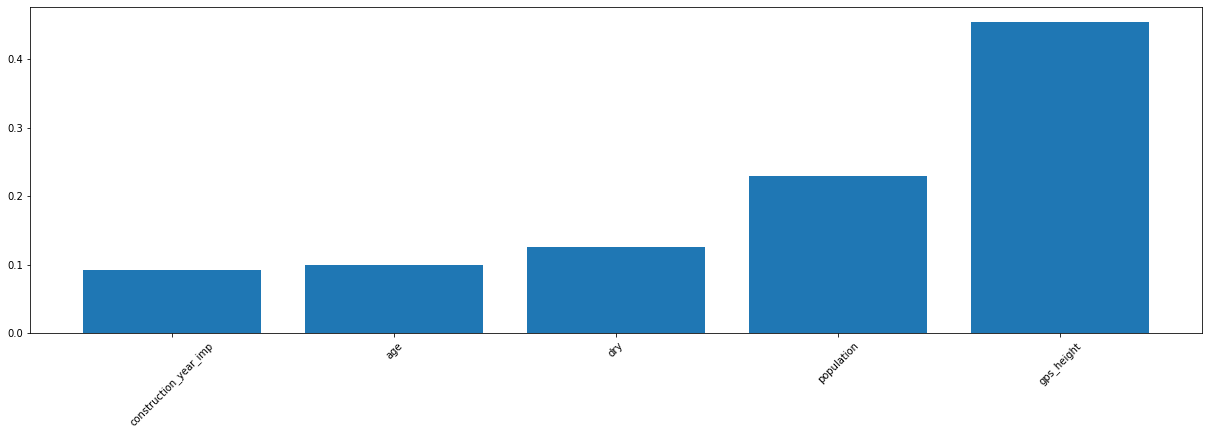

In [303]:
feature_label = pumps_subset.columns
feature_importance_idx =np.argsort(rf_cv.feature_importances_)
feature_importance_sorted = []
for idx in feature_importance_idx:
    feature_importance_sorted.append(rf_cv.feature_importances_[idx])
feature_label_sorted = []
for idx in feature_importance_idx:
    feature_label_sorted.append(pumps_subset.columns[idx])
fig= plt.figure(figsize=(21,6))
plt.bar(feature_label_sorted, feature_importance_sorted)
plt.xticks(rotation=45)
plt.show()